<a href="https://colab.research.google.com/github/himanshu-dutta/MLPMixer-pytorch/blob/master/MLP_Mixer_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri May 28 13:24:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -qq pytorch-lightning
!pip install -qq torchinfo

     |████████████████████████████████| 808kB 14.1MB/s 
     |████████████████████████████████| 829kB 25.6MB/s 
     |████████████████████████████████| 645kB 47.2MB/s 
     |████████████████████████████████| 10.6MB 51.4MB/s 
     |████████████████████████████████| 276kB 48.6MB/s 
     |████████████████████████████████| 112kB 56.2MB/s 
     |████████████████████████████████| 1.3MB 46.2MB/s 
     |████████████████████████████████| 143kB 53.2MB/s 
     |████████████████████████████████| 296kB 43.2MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.


In [3]:
!pip install -q mlp-mixer

In [4]:
import os
import torch
import torchvision
import torch.nn as nn
import pytorch_lightning as pl

from tqdm.notebook import tqdm
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import Iterable, Callable, Dict

from mlp_mixer import MLPMixer

In [5]:
BS = 64

IMG_SZ = 28
IMG_CHANNELS = 1
NUM_CLASSES = 10

NUM_PATCHES = 49
NUM_CHANNELS = 256

DEPTH = 20
EPOCHS = 10
EXPANSION = 8
DROPOUT = 0.1

# Data

In [6]:
train_dl = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "./data/",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            [   
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=BS,
    shuffle=True,
    num_workers=os.cpu_count(),
)

val_dl = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "./data/",
        train=False,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=BS,
    num_workers=os.cpu_count(),
)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# MLP Mixer

In [7]:
class Model(pl.LightningModule):
    def __init__(
        self,
        img_sz,
        img_channels,
        num_classes,
        depth,
        num_patches,
        num_channels,
        expansion,
        dropout,
        lr=2e-4
    ):
        super(Model, self).__init__()
        self.lr = lr
        self.model = MLPMixer(img_sz,
                        img_channels,
                        num_classes,
                        depth,
                        num_patches,
                        num_channels,
                        expansion,
                        dropout,
                      )

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)


    def training_step(self, xb, batch_idx):
        inp, labels = xb
        out = self(inp)

        return self.loss(out, labels)

    def validation_step(self, xb, batch_idx):
        inp, labels = xb
        out = self(inp)

        labels_hat = torch.argmax(out, dim=1)
        val_acc = torch.sum(labels == labels_hat).item() / (len(labels) * 1.0)

        self.log(
            "val_loss",
            self.loss(out, labels),
            prog_bar=True,
            on_step=False,
            on_epoch=True,
        )
        self.log("val_acc", val_acc, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Evaluation

In [8]:
class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            self._features[layer_id] = output

        return fn

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        _ = self.model(x)
        return self._features

In [9]:
@torch.no_grad()
def eval(model, val_dl, layer):

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = model.eval()

    model = FeatureExtractor(model, [layer]).to(device)

    ys = []
    outs = []
    for x, y in tqdm(val_dl):
        out = model(x.to(device)).get(layer).detach()
        outs.append(out.reshape(x.shape[0], -1))
        ys.append(y)

    outs = torch.cat(outs, dim=0).cpu()
    ys = torch.cat(ys, dim=0).cpu()

    decomposer = PCA(n_components=3)
    decomposed = decomposer.fit_transform(outs.numpy())

    colors = {
        1: "blue",
        2: "orange",
        3: "green",
        4: "red",
        5: "purple",
        6: "brown",
        7: "pink",
        8: "gray",
        9: "olive",
        0: "cyan",
    }

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    ax.scatter(
        xs=decomposed[:, 0],
        ys=decomposed[:, 1],
        zs=decomposed[:, 2],
        c=list(map(lambda x: colors[int(x)], list(ys))),
    )
    plt.show()

# Execution

In [10]:
model = Model(
    IMG_SZ,
    img_channels=IMG_CHANNELS,
    num_classes=NUM_CLASSES,
    depth=DEPTH,
    num_patches=NUM_PATCHES,
    num_channels=NUM_CHANNELS,
    expansion=EXPANSION,
    dropout=DROPOUT,
)

print(summary(model, input_size=(1, IMG_CHANNELS, IMG_SZ, IMG_SZ)))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─MLPMixer: 1-1                          [1, 10]                   --
│    └─Linear: 2-1                       [1, 49, 256]              4,352
│    └─ModuleList: 2                     --                        --
│    │    └─MixerLayer: 3-1              [1, 49, 256]              1,090,761
│    │    └─MixerLayer: 3-2              [1, 49, 256]              1,090,761
│    │    └─MixerLayer: 3-3              [1, 49, 256]              1,090,761
│    │    └─MixerLayer: 3-4              [1, 49, 256]              1,090,761
│    │    └─MixerLayer: 3-5              [1, 49, 256]              1,090,761
│    │    └─MixerLayer: 3-6              [1, 49, 256]              1,090,761
│    │    └─MixerLayer: 3-7              [1, 49, 256]              1,090,761
│    │    └─MixerLayer: 3-8              [1, 49, 256]              1,090,761
│    │    └─MixerLayer: 3-

In [11]:
trainer = pl.Trainer(
    default_root_dir="logs",
    gpus=(1 if torch.cuda.is_available() else 0),
    max_epochs=EPOCHS,
    logger=pl.loggers.TensorBoardLogger("logs/", name="mlp_mixer_mnist", version=0),
    precision=16,
)

trainer.fit(model, train_dataloader=train_dl, val_dataloaders=val_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | MLPMixer         | 21.8 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
21.8 M    Trainable params
0         Non-trainable params
21.8 M    Total params
87.289    Total estimated model params size (MB)


In [12]:
model = model.cuda().eval()
ys = []
outs = []

with torch.no_grad():
    for x, y in tqdm(val_dl): 
        out = model(x.cuda()).detach()
        outs.append(out.reshape(x.shape[0], -1))
        ys.append(y)

outs = torch.cat(outs, dim=0).cpu()
labels = torch.cat(ys, dim=0).cpu()

labels_hat = torch.argmax(outs, dim=1)
val_acc = torch.sum(labels == labels_hat).item() / (len(labels) * 1.0)

print("\nValidation Accuracy: ", round(100*val_acc, 4))



Validation Accuracy:  98.18


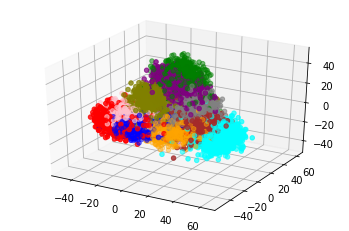

In [13]:
eval(model, val_dl, "model.identity")